In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import xarray as xr

In [2]:
### Identify data
dir_in = Path('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/data/spinner/obs')
files_in = list(dir_in.glob('*.nc'))
files_in.sort()

f_out = Path(dir_in, 'real_gridded.nc')
if f_out in files_in:
    files_in.remove(f_out)

In [3]:
### Concatenate all files along the time axis
all_ds_list = []
for f_in in files_in:
    ## Read in the three data groups
    ds_in = xr.open_dataset(f_in)
    
    ## Reformat the data
    # Initialize new Dataset
    start_time = ds_in['time'].values.flatten(order='C')[0]
    rel_time = ds_in['time'].values.flatten(order='C') - ds_in['time'].values.flatten(order='C')[0]
    nan_time_flag = ~np.isnan(rel_time)
    ref_time = pd.Timestamp('January 1 1970')
    time = ref_time + (start_time + rel_time[nan_time_flag]) * timedelta(seconds=1)
    coords = {'time': time}
    ds_tmp = xr.Dataset(coords)

    # Populate with data
    # ds_varnames = list(ds_in.variables)
    # ds_varnames.remove('time')
    ds_varnames = ['x_nacelleCS', 'y_nacelleCS', 'z_nacelleCS', 'vlos', 'u_nacelleCS', 'v_nacelleCS']
    for varname in ds_varnames:
        ds_tmp[varname] = (('time'), ds_in[varname].data.flatten(order='C')[nan_time_flag])
        
    all_ds_list.append(ds_tmp.copy())
ds = xr.concat(all_ds_list, dim='time')

In [4]:
f_in

PosixPath('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/data/spinner/obs/snl.lidar.z01.b1.20230724.163000.nc')

In [5]:
### Center coords on the turbine
ds['y_nacelleCS'].data = ds['y_nacelleCS'].data - np.mean(ds['y_nacelleCS'].data)
ds['z_nacelleCS'].data = ds['z_nacelleCS'].data - np.mean(ds['z_nacelleCS'].data)

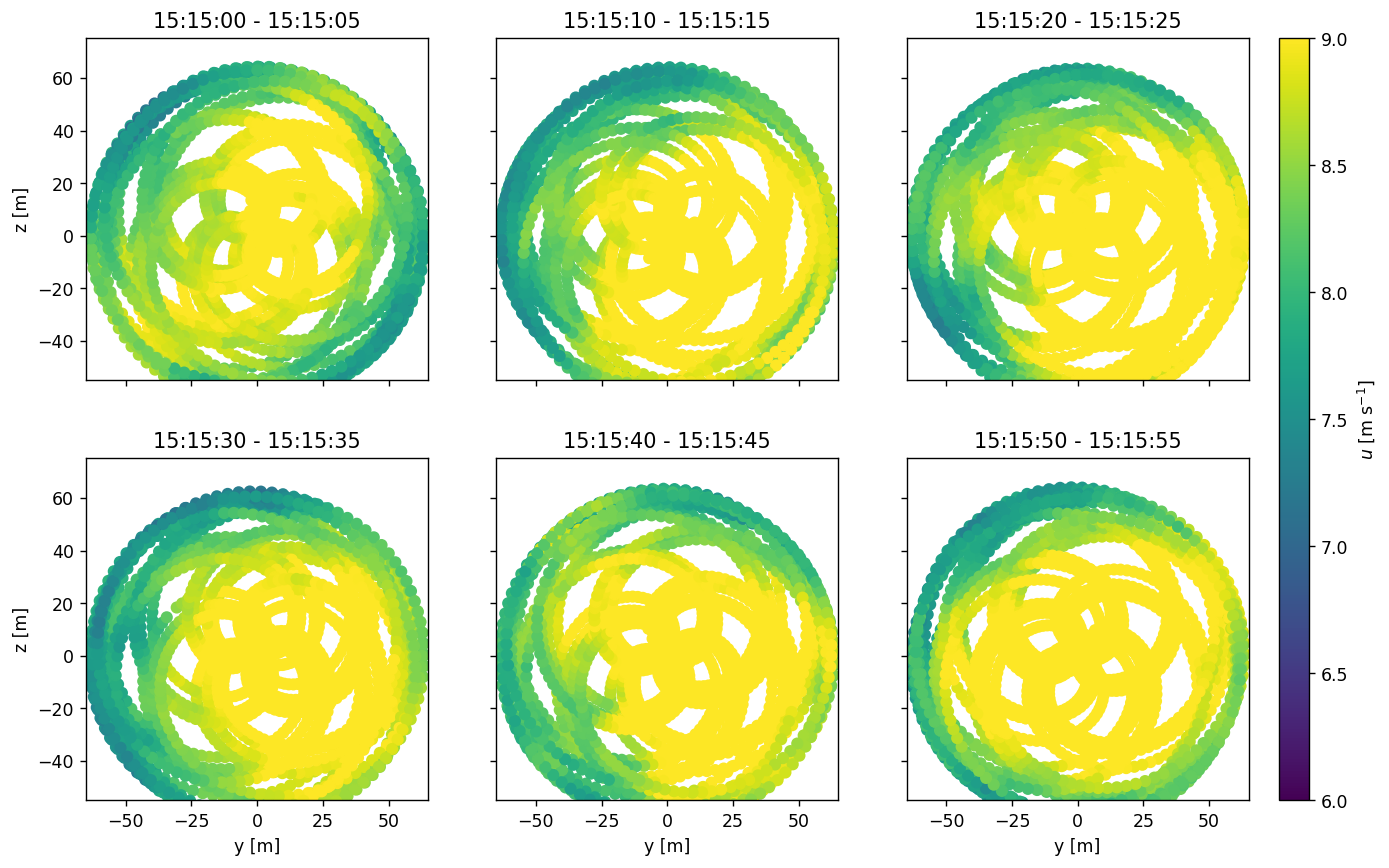

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(12,8), dpi=125, sharex=True, sharey=True)

## Decorate
ymin_plt, ymax_plt = -65, 65
zmin_plt, zmax_plt = -55, 75
ax[0,0].set_xlim(ymin_plt, ymax_plt)
ax[0,0].set_ylim(zmin_plt, zmax_plt)

for axs in ax[-1,:]:
    axs.set_xlabel('y [m]')
for axs in ax[:,0]:
    axs.set_ylabel('z [m]')

vmin, vmax = 6, 9

for axs in ax.flatten():
    axs.set_box_aspect(1)

## Data
start_time = pd.Timestamp('2023-07-24T15:15:00')
end_time = start_time + timedelta(seconds=5)
ds_trim = ds.sel(time=slice(start_time, end_time))

for i, axs in enumerate(ax.flatten()):
    axs.set_title(f'{start_time.strftime("%H:%M:%S")} - {end_time.strftime("%H:%M:%S")}')
    im0 = axs.scatter(ds_trim['y_nacelleCS'],
               ds_trim['z_nacelleCS'],
               c=ds_trim['vlos'],
               vmin=vmin,
               vmax=vmax,
               cmap='viridis')
    
    start_time = start_time + timedelta(seconds=10)
    end_time = end_time + timedelta(seconds=10)
    ds_trim = ds.sel(time=slice(start_time, end_time))

cax0 = fig.add_axes([ax[0,-1].get_position().x1+0.02,
                     ax[-1,-1].get_position().y0,
                     0.02,
                     ax[0,-1].get_position().y1-ax[-1,-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()


plt.show()

# Create a gridded version of spinner measurements

In [7]:
### Create a gridded version of spinner measurements
## Grid properties
dy_grid, dz_grid = 10, 10  # meters
dt_grid = 5  # sec
tgrid_start = pd.Timestamp(ds['time'].values[0]).ceil(freq='s')
tgrid_end = pd.Timestamp(ds['time'].values[-1]).floor(freq='s')
tgrid = pd.date_range(tgrid_start, tgrid_end, freq=f'{dt_grid}s')

## Initialize an Xarray Dataset
ycoords = np.arange(-80, 80+dy_grid, dy_grid)
zcoords = np.arange(-80, 80+dz_grid, dz_grid)
# zcoords = ycoords


coords_grid = {'y': ycoords,
               'z': zcoords,
               'time': tgrid}

ds_grid = xr.Dataset(coords_grid)

## Populate Dataset
vlos_gridded = np.zeros((len(ycoords), len(zcoords), len(tgrid)))

# Binned statistic approach
#   See the following for helpful context
#   https://stackoverflow.com/questions/66673822/is-there-a-way-to-bin-a-set-of-2d-coordinates-in-python
#   https://stackoverflow.com/questions/68984073/how-to-put-a-grid-for-example-dividing-the-x-y-plane-into-bins-on-an-image-t
ycoords4binning = np.append(ycoords, ycoords[-1]+dy_grid)
zcoords4binning = np.append(zcoords, zcoords[-1]+dz_grid)
for tstep in range(len(tgrid)-1):
    # Trim to sub-period
    start_time, end_time = tgrid[tstep], tgrid[tstep+1]
    ds_trim = ds.sel(time=slice(start_time, end_time))
    
    # Bin
    ycoord_data = ds_trim['y_nacelleCS'].values
    zcoord_data = ds_trim['z_nacelleCS'].values
    vlos_data = ds_trim['vlos'].values
    
    # Purge NaN vlos measurements
    nan_vlos_flag = ~np.isnan(vlos_data)  
    ycoord_data = ycoord_data[nan_vlos_flag]
    zcoord_data = zcoord_data[nan_vlos_flag]
    vlos_data = vlos_data[nan_vlos_flag]
    
    binned_results = binned_statistic_2d(x=ycoord_data,
                                         y=zcoord_data,
                                         values=vlos_data,
                                         statistic='mean',
                                         bins=(ycoords4binning, zcoords4binning))
    
    vlos_gridded[:,:,tstep] = binned_results.statistic.copy()
    
ds_grid['vlos'] = (('y', 'z', 'time'), vlos_gridded)
ds_grid.to_netcdf(f_out)

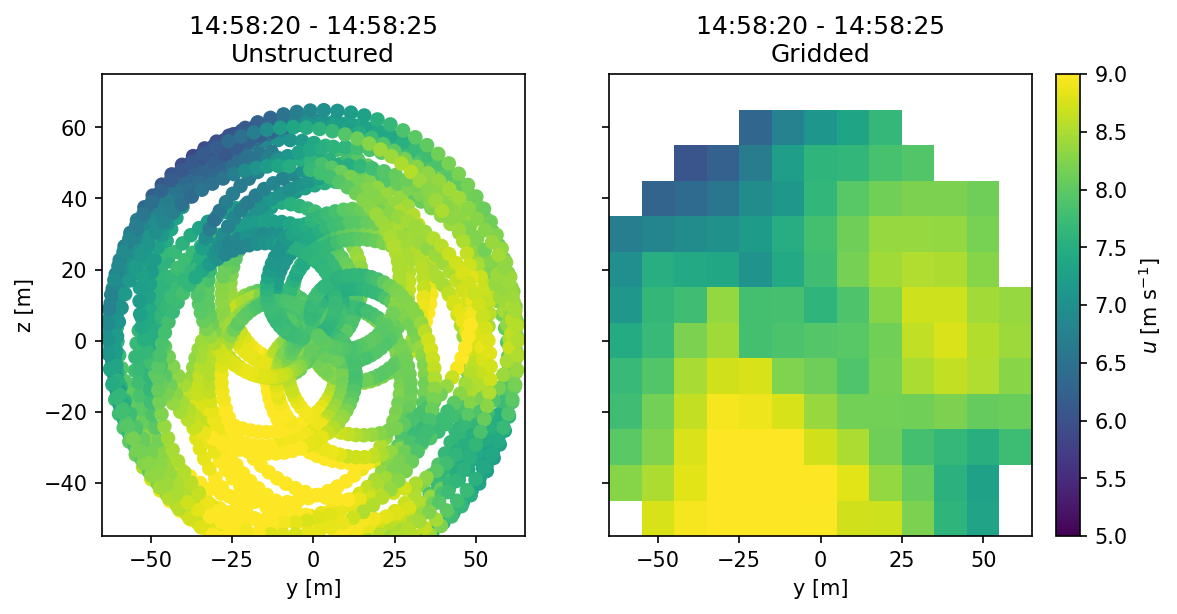

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=150, sharex=True, sharey=True)

## Decorate
ax[0].set_xlim(ymin_plt, ymax_plt)
ax[0].set_ylim(zmin_plt, zmax_plt)

for axs in ax:
    axs.set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')

vmin, vmax = 5, 9

# for axs in ax:
#     axs.set_box_aspect(1)

# Data
start_time, end_time = tgrid[100], tgrid[101]
ds_trim = ds.sel(time=slice(start_time, end_time))

ax[0].set_title(f'{start_time.strftime("%H:%M:%S")} - {end_time.strftime("%H:%M:%S")}\nUnstructured')
im0 = ax[0].scatter(ds_trim['y_nacelleCS'],
           ds_trim['z_nacelleCS'],
           c=ds_trim['vlos'],
           vmin=vmin,
           vmax=vmax,
           cmap='viridis')


ax[1].set_title(f'{start_time.strftime("%H:%M:%S")} - {end_time.strftime("%H:%M:%S")}\nGridded')
im1 = ax[1].pcolormesh(ds_grid['y'],
                       ds_grid['z'],
                       ds_grid['vlos'].sel(time=start_time).values.T,
                       vmin=vmin,
                       vmax=vmax)


cax0 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[-1].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

# plt.savefig('figs/spinner_lidar_gridded_demo.png', bbox_inches='tight')

plt.show()